<a href="https://colab.research.google.com/github/Dunckleosteus/seismic/blob/Penis/seismic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [158]:
!pip install bruges

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bruges
import bruges.filters as bf

In [160]:
!rm data.zip
!rm -r data
!wget https://github.com/Dunckleosteus/seismic/raw/18908e9e23b56529c5744c96fac2a5216cd298cd/data.zip
!unzip data.zip

--2025-03-21 14:41:10--  https://github.com/Dunckleosteus/seismic/raw/18908e9e23b56529c5744c96fac2a5216cd298cd/data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Dunckleosteus/seismic/18908e9e23b56529c5744c96fac2a5216cd298cd/data.zip [following]
--2025-03-21 14:41:11--  https://raw.githubusercontent.com/Dunckleosteus/seismic/18908e9e23b56529c5744c96fac2a5216cd298cd/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1512 (1.5K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1.48K  --.-KB/s    in 0s      

2025-03-21 14:41:11 (24.9 MB/s) - ‘da

In [161]:
rhob = pd.read_csv('data/rhob.csv', index_col=0)
rhob

,0;2300,0;2300.1,0;2300.2,0;2300.3,0;2300.4,0;2300.5,0;2300.6,0;2300.7,0;2300.8,0;2300.9,...,0;2300.21,0;2300.22,0;2300.23,0;2300.24,0;2300.25,0;2300.26,0;2300.27,0;2300.28,0;2300.29,0
2300,,,,,,,,,,,,,,,,,,,,,
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0


In [162]:

df_path_list = [
    "data/rhob.csv",
    "data/vph.csv",
    "data/x.csv",
    "data/y.csv",
]
df_list = [pd.read_csv(path, index_col=None, header=None, sep=";") for path in df_path_list]
[df.dropna(inplace=True) for df in df_list]
for df in df_list:
  for col in df.columns:
    try:
      df[col] = df[col].str.replace(",", ".").astype(float).values
    except:
      df.values

array = np.stack(df_list)
array.shape

(4, 13, 31)

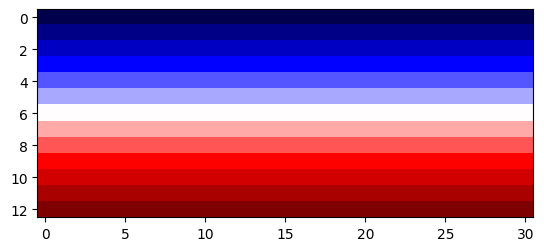

In [163]:
plt.imshow(np.flip(array[3, :, :]))

# Accoustic impedance
The formula for accoustic impedance is :
$$I_i=\rho_i \times v_i$$

So to calculate it, we simply need to multiply the first layer in array to the second one.

Text(0.5, 1.0, 'Accoustic impedance')

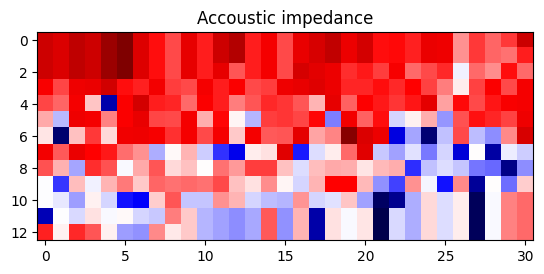

In [164]:
impedance_matrix = np.flip(array[0, :, :] * array[1, :, :])
plt.imshow(impedance_matrix)
plt.title("Accoustic impedance")

# Reflection coefficient
$$R_o=\frac{I_{i+1}-I_i}{I_{i+1}+I_i}$$
Where I is the impedance calculated above.

This operation is 1D and is deployed on vertical axis. Here are vertical axis is represented by y.

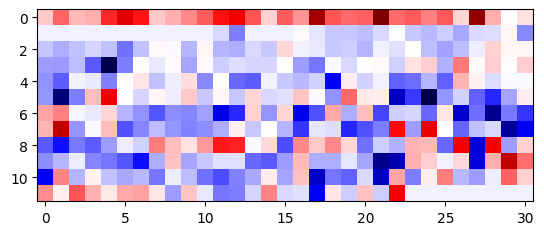

In [165]:
I     = np.roll(impedance_matrix, shift=1, axis=0)[:-1, :] # n+1
In1  = impedance_matrix[1:, :] # n
reflection_coeff = (In1 - I) / (In1 + I)
plt.imshow(reflection_coeff)

In [166]:
time_matrix = (0.2 / array[1, :, :])
time_matrix = np.cumsum(time_matrix, axis=0) * 2 # time matrix in seconds

## Fish bone plot
This represents the variations along a given vertical axis.

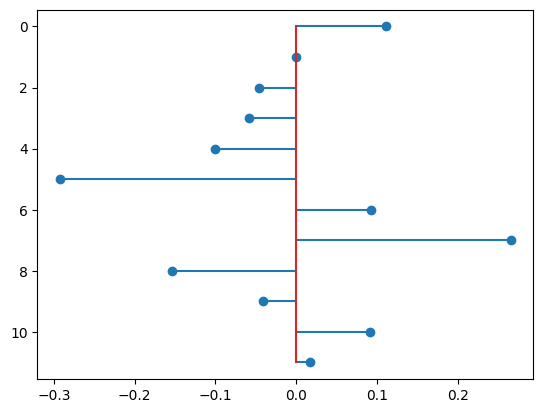

In [167]:
plt.stem(reflection_coeff[:, 1], orientation='horizontal')
plt.gca().invert_yaxis()

# Seismic wavelet

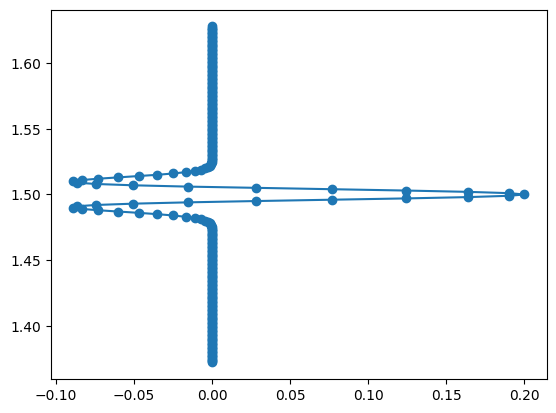

In [168]:

def create_wavelet(offset, amplitude, length=0.256, frequency=40, sample_intervall=0.01):
  w, t = bf.ricker(length, sample_intervall, frequency)
  t += offset
  w *= amplitude
  return w,t

w, t = create_wavelet(1.5, 0.2, sample_intervall=0.001)
plt.plot(w, t)
plt.scatter(w,t )

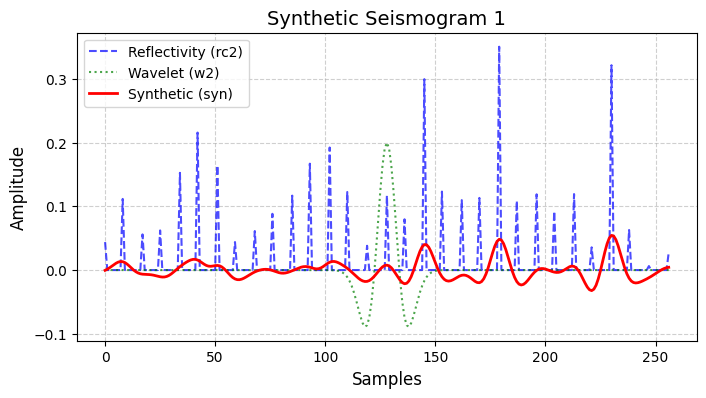

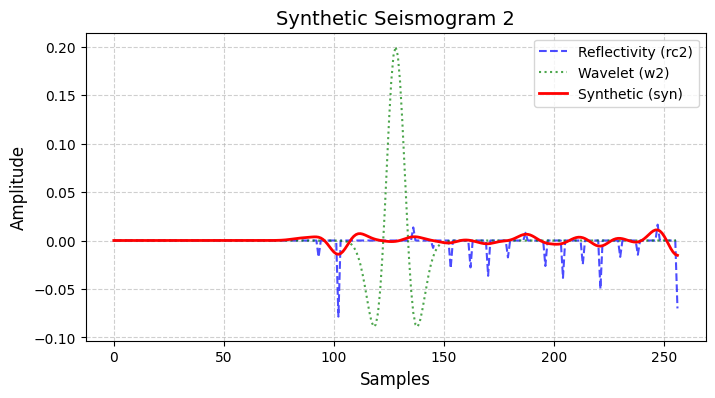

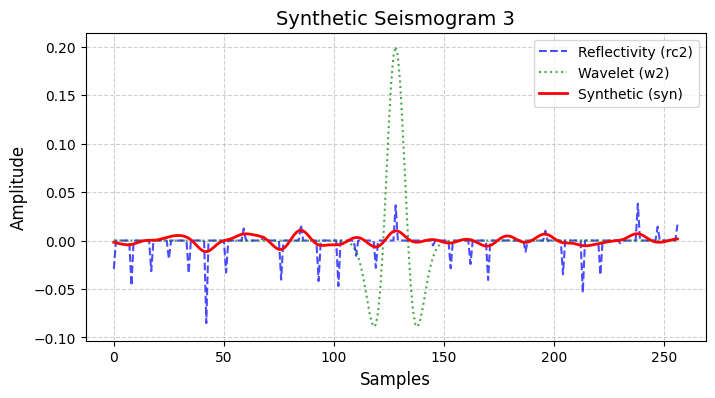

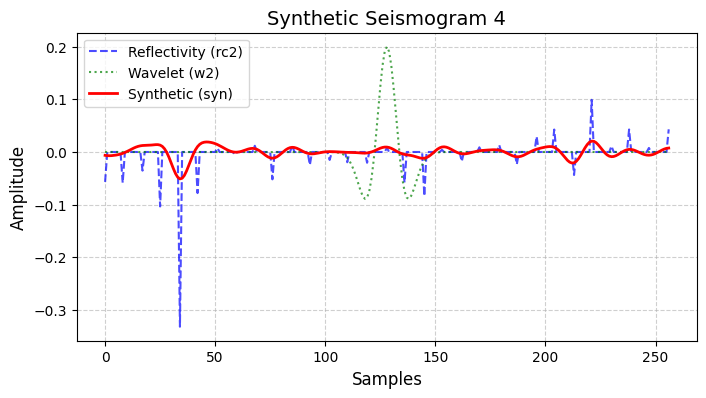

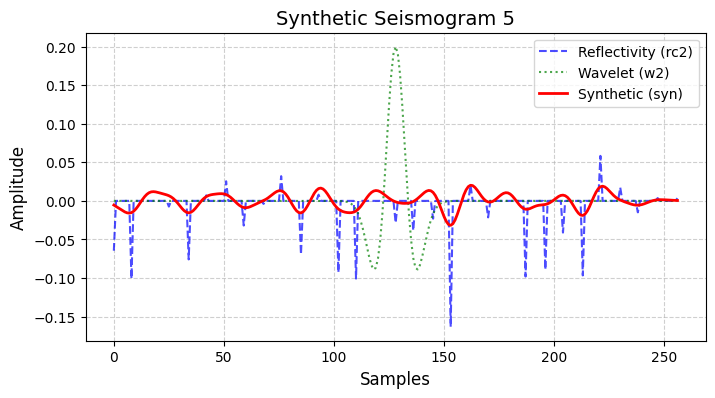

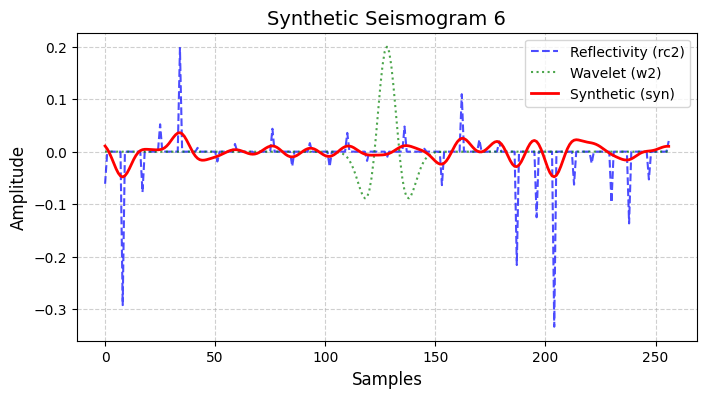

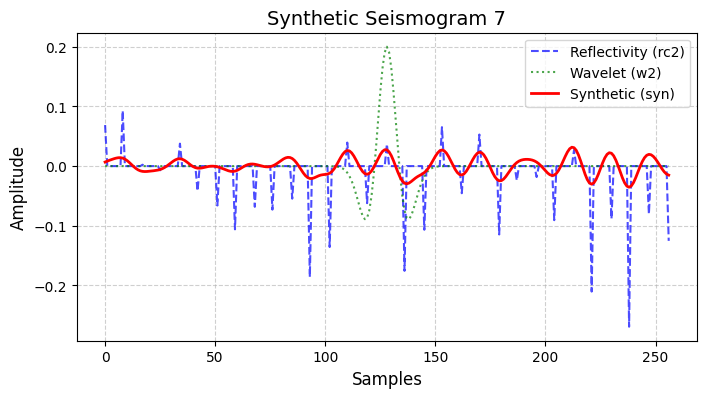

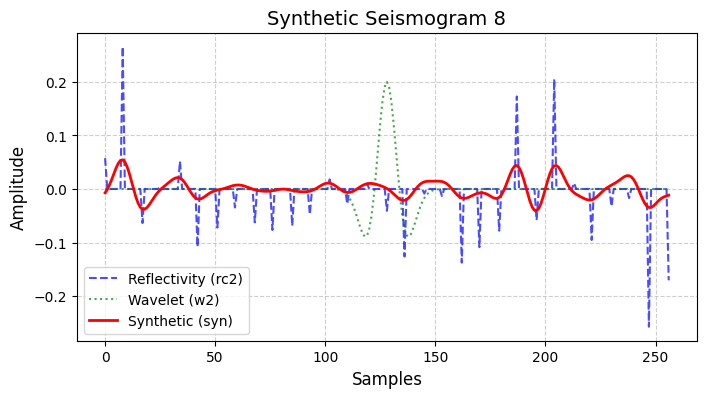

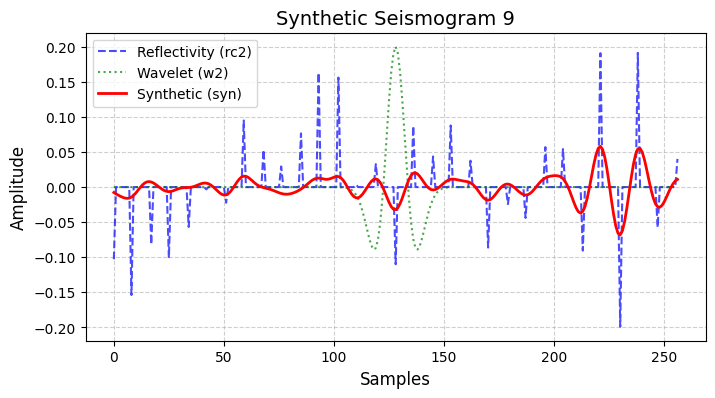

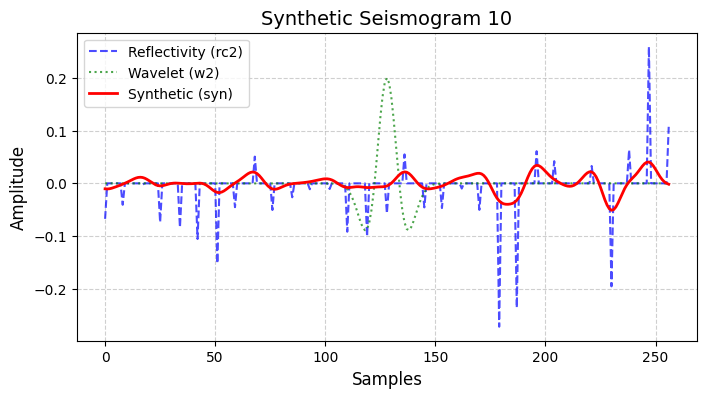

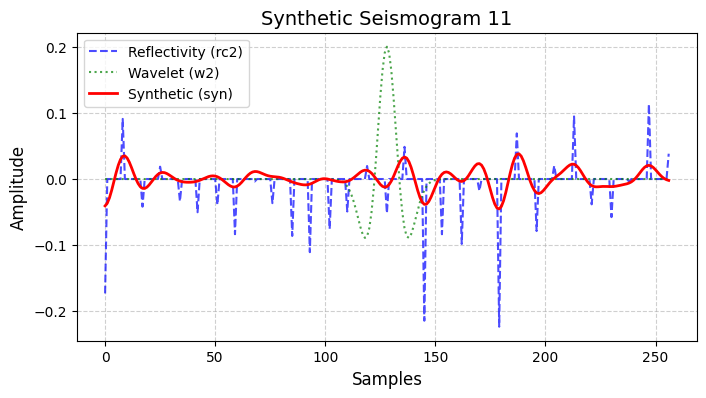

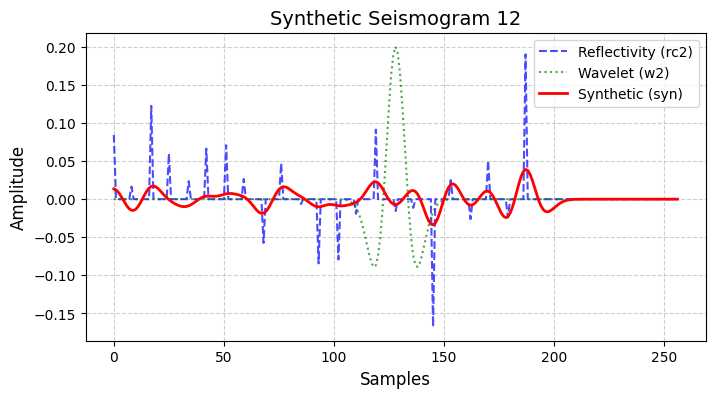

In [169]:
import numpy as np

rc = reflection_coeff[:,1]

def expand_with_zeros(arr, target_length): #fill des valeurs manquantes par des 0 pour ne pas modifier la données
    if len(arr) == target_length:
        return arr

    new_arr = np.zeros(target_length)
    indices = np.linspace(0, target_length - 1, len(arr), dtype=int)

    for i, index in enumerate(indices):
        new_arr[index] = arr[i]

    return list(new_arr)

def equalize_arrays(arr1, arr2): #faire en sorte que les deux arrays aient le meme nombre de points
    max_length = max(len(arr1), len(arr2))

    arr1_expanded = expand_with_zeros(arr1, max_length)
    arr2_expanded = expand_with_zeros(arr2, max_length)

    return arr1_expanded, arr2_expanded



rc2, w2 = equalize_arrays(rc, w)

#version numpy

syn = np.convolve(rc2, w2, mode='same')

#version bruges
#import bruges as bg

#rc2 = np.array(rc2)
#w2 = np.array(w2)
#synbg = bg.filters.convolve(rc2, w2)


import numpy as np
import matplotlib.pyplot as plt

for i, rc in enumerate(reflection_coeff):
    rc2, w2 = equalize_arrays(rc, w)  # Égalisation des longueurs
    syn = np.convolve(rc2, w2, mode='same')  # Convolution

    plt.figure(figsize=(8, 4))

    plt.plot(rc2, label='Reflectivity (rc2)', color='b', linestyle='dashed', alpha=0.7)
    plt.plot(w2, label='Wavelet (w2)', color='g', linestyle='dotted', alpha=0.7)
    plt.plot(syn, label='Synthetic (syn)', color='r', linewidth=2)
    plt.title(f'Synthetic Seismogram {i+1}', fontsize=14)
    plt.xlabel('Samples', fontsize=12)
    plt.ylabel('Amplitude', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()






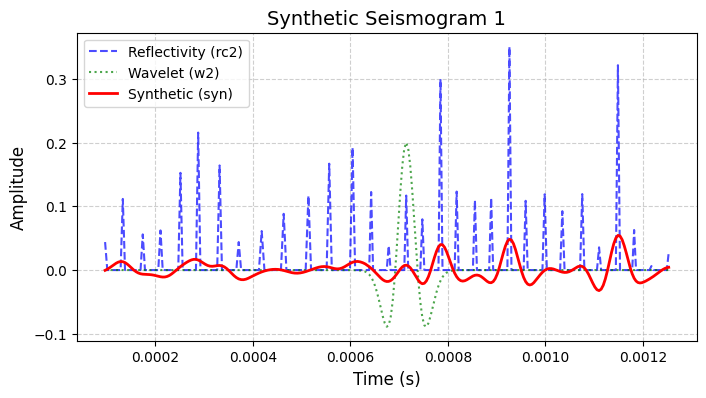

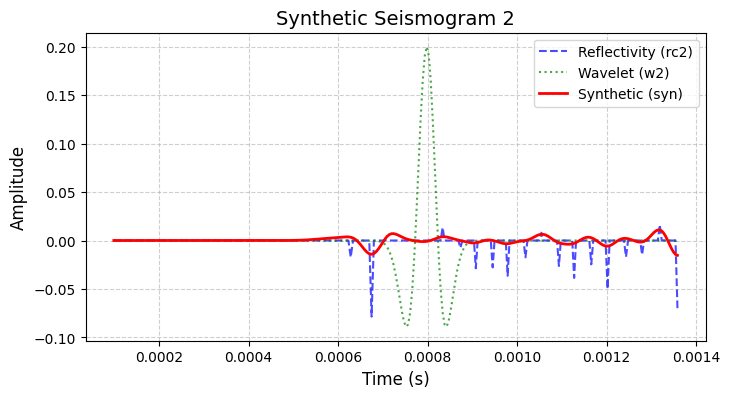

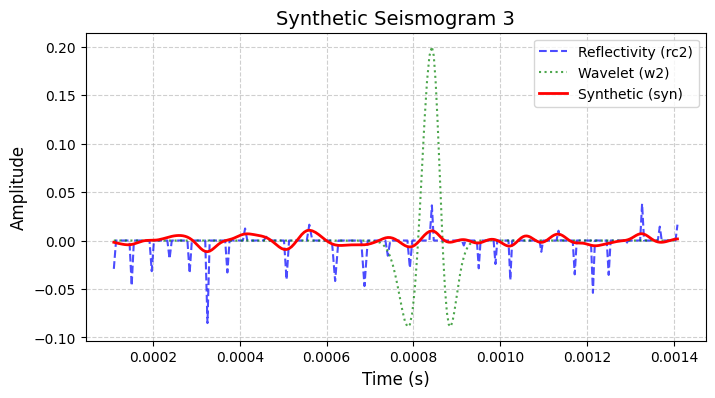

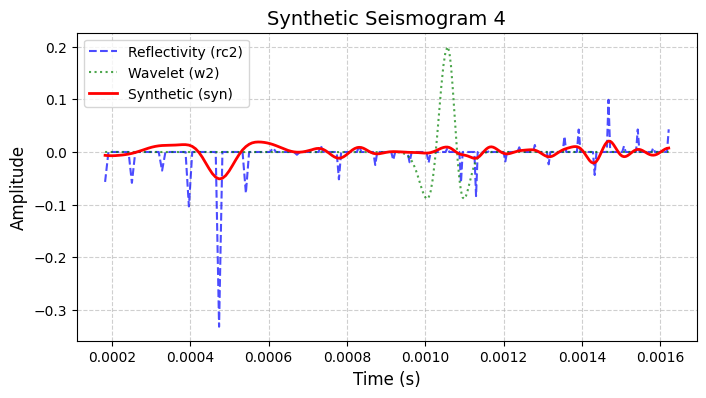

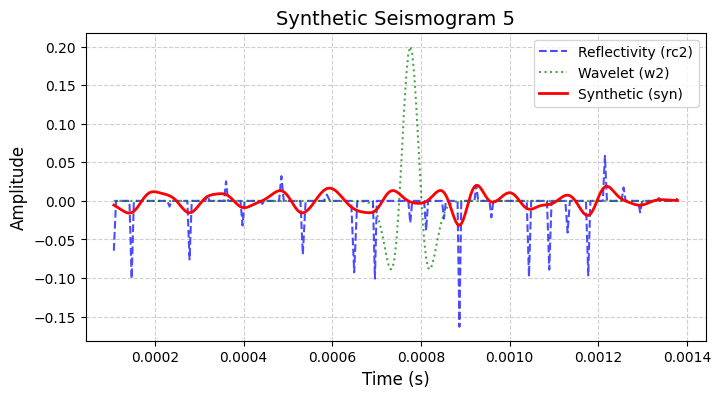

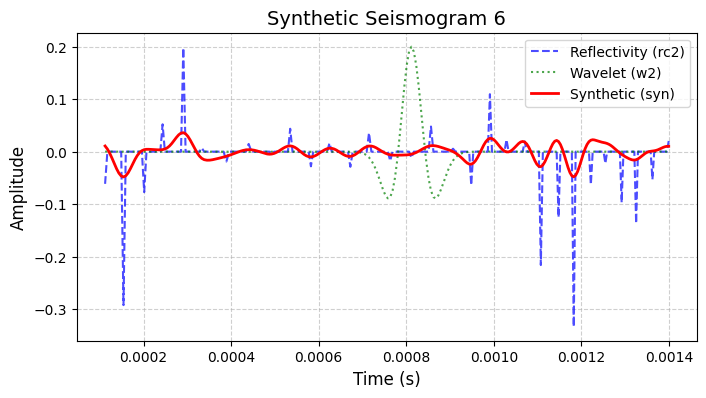

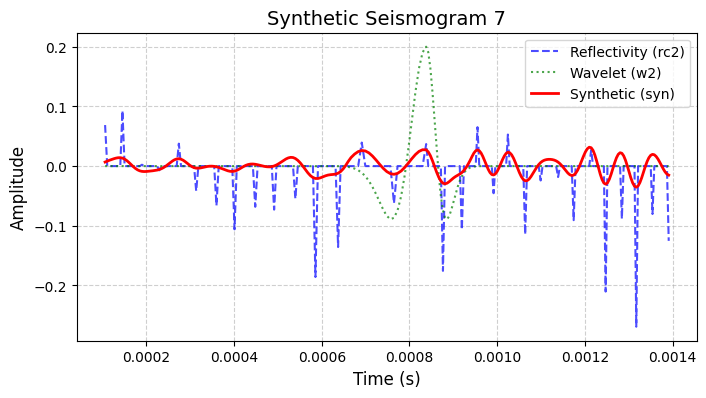

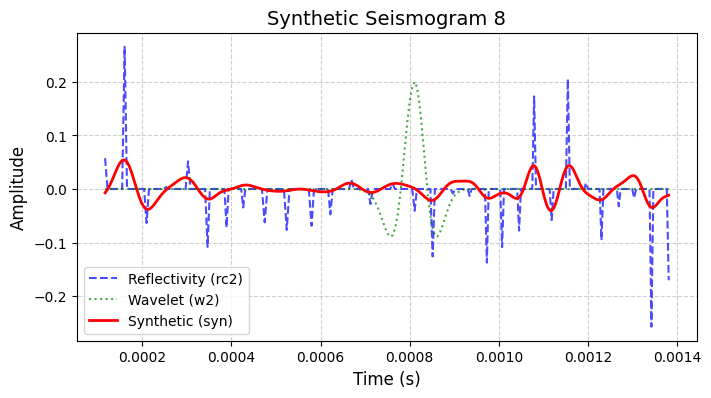

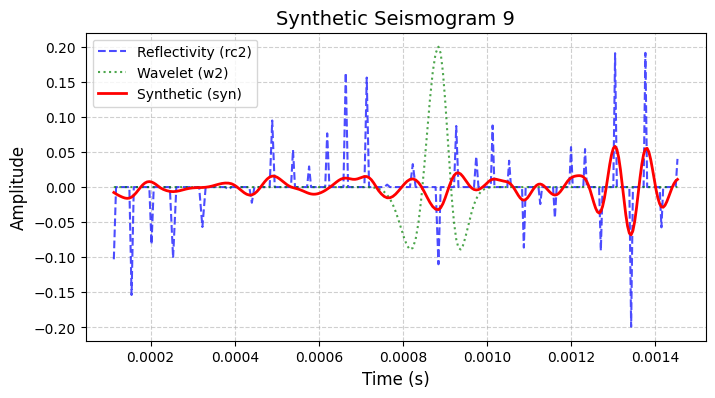

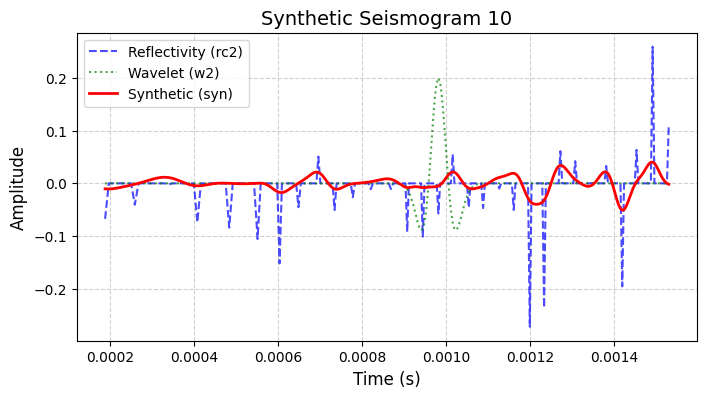

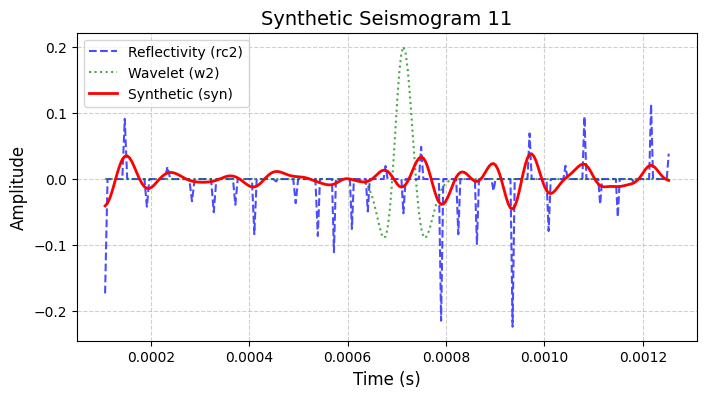

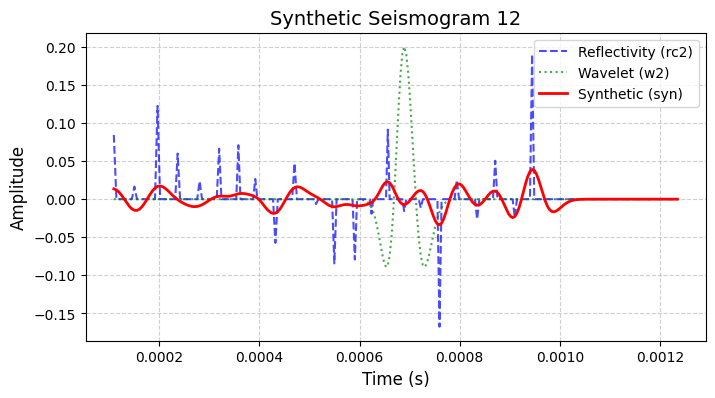

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

for i, rc in enumerate(reflection_coeff):
    rc2, w2 = equalize_arrays(rc, w)  # Égalisation des longueurs
    syn = np.convolve(rc2, w2, mode='same')  # Convolution

    # Extraction du temps correspondant à rc
    time_original = time_matrix[:, i]  # Temps original pour cette trace

    # Vérification de la taille de time_matrix
    if len(time_original) != len(rc2):
        # Interpolation linéaire pour rééchantillonner le temps
        f = interp1d(np.linspace(0, 1, len(time_original)), time_original, kind='linear', fill_value="extrapolate")
        time_resampled = f(np.linspace(0, 1, len(rc2)))
    else:
        time_resampled = time_original

    # Création d'une nouvelle figure
    plt.figure(figsize=(8, 4))

    # Tracé des courbes avec time_matrix sur l'axe des x
    plt.plot(time_resampled, rc2, label='Reflectivity (rc2)', color='b', linestyle='dashed', alpha=0.7)
    plt.plot(time_resampled, w2, label='Wavelet (w2)', color='g', linestyle='dotted', alpha=0.7)
    plt.plot(time_resampled, syn, label='Synthetic (syn)', color='r', linewidth=2)

    # Ajout de titre et légende
    plt.title(f'Synthetic Seismogram {i+1}', fontsize=14)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Amplitude', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Affichage
    plt.show()


In [171]:
time_resampled.shape

(257,)

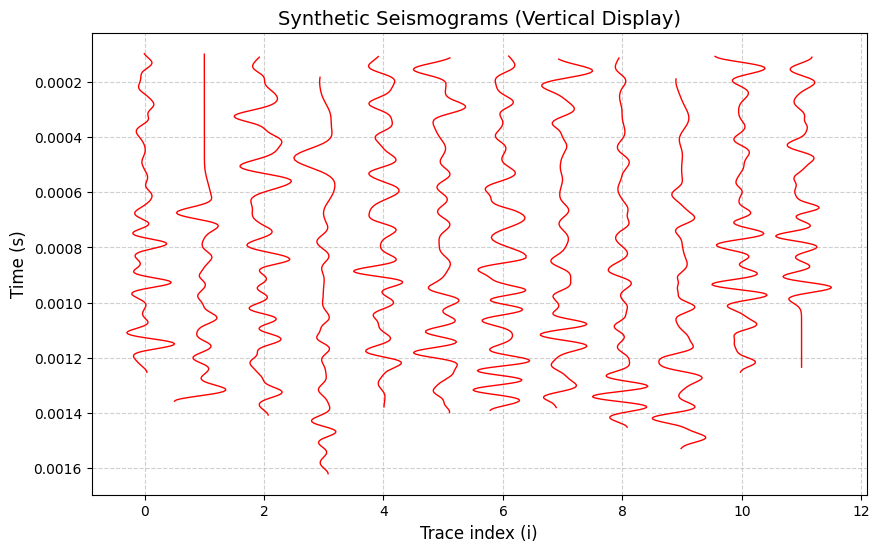

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

plt.figure(figsize=(10, 6))  # Taille du graphique

for i, rc in enumerate(reflection_coeff):
    rc2, w2 = equalize_arrays(rc, w)  # Égalisation des longueurs
    syn = np.convolve(rc2, w2, mode='same')  # Convolution

    # Extraction du temps correspondant à rc
    time_original = time_matrix[:, i]

    # Vérification et interpolation du temps si nécessaire
    if len(time_original) != len(rc2):
        f = interp1d(np.linspace(0, 1, len(time_original)), time_original, kind='linear', fill_value="extrapolate")
        time_resampled = f(np.linspace(0, 1, len(rc2)))
    else:
        time_resampled = time_original

    # Normalisation et recentrage de syn autour de X = i
    syn_norm = syn / np.max(np.abs(syn)) * 0.5  # Mise à l'échelle pour éviter le chevauchement
    x_values = syn_norm + i  # Décalage en X pour l'alignement

    # Tracé du sismogramme à la verticale
    plt.plot(x_values, time_resampled, color='r', linewidth=1)

# Personnalisation du plot
plt.gca().invert_yaxis()  # Mettre l'origine du temps en haut
plt.xlabel('Trace index (i)', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.title('Synthetic Seismograms (Vertical Display)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

# Affichage
plt.show()


![image.png]( )

       x     amplitude     temps
0      0 -8.665654e-03  0.000097
1      0  2.431542e-02  0.000102
2      0  6.384503e-02  0.000106
3      0  1.086061e-01  0.000111
4      0  1.550996e-01  0.000115
...   ..           ...       ...
3079  11 -1.367188e-27  0.001218
3080  11 -1.781462e-28  0.001222
3081  11 -2.248043e-29  0.001226
3082  11 -2.747381e-30  0.001231
3083  11 -3.251811e-31  0.001235

[3084 rows x 3 columns]


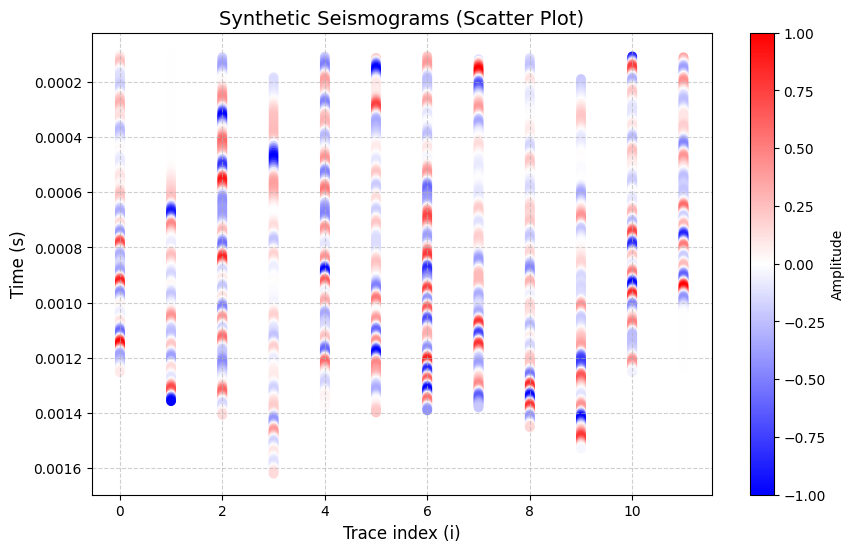

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d



# Initialisation des listes pour stocker les données
x_values_list = []
amplitude_list = []
time_list = []

for i, rc in enumerate(reflection_coeff):
    rc2, w2 = equalize_arrays(rc, w)  # Égalisation des longueurs
    syn = np.convolve(rc2, w2, mode='same')  # Convolution

    # Extraction du temps correspondant à rc
    time_original = time_matrix[:, i]

    # Vérification et interpolation du temps si nécessaire
    if len(time_original) != len(rc2):
        f = interp1d(np.linspace(0, 1, len(time_original)), time_original, kind='linear', fill_value="extrapolate")
        time_resampled = f(np.linspace(0, 1, len(rc2)))
    else:
        time_resampled = time_original

    # Normalisation
    syn_norm = syn / np.max(np.abs(syn))  # Normalisation

    # Stockage des données dans les listes
    for amp, t in zip(syn_norm, time_resampled):
        x_values_list.append(i)
        amplitude_list.append(amp)
        time_list.append(t)

# Création du DataFrame
data = {
    'x': x_values_list,
    'amplitude': amplitude_list,
    'temps': time_list
}
df = pd.DataFrame(data)

# Affichage du DataFrame
print(df)




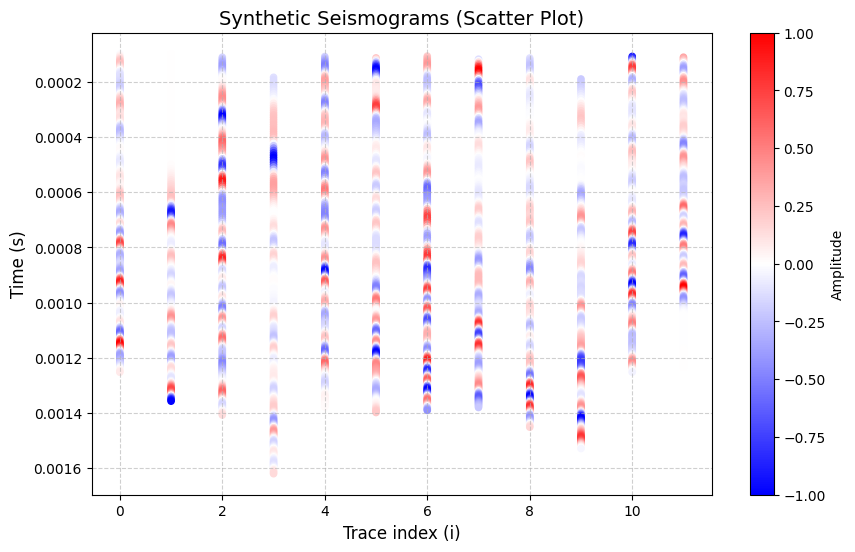

In [191]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(df['x'], df['temps'], c=df['amplitude'], cmap='bwr', marker='o', s=20)  # Ajustez 's' pour la taille des points
plt.colorbar(sc, label='Amplitude')

# Personnalisation du plot
plt.xlabel('Trace index (i)', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.title('Synthetic Seismograms (Scatter Plot)', fontsize=14)
plt.gca().invert_yaxis()  # Mettre l'origine du temps en haut
plt.grid(True, linestyle='--', alpha=0.6)

# Affichage
plt.show()